# 树模型基础

## 节点分裂标准

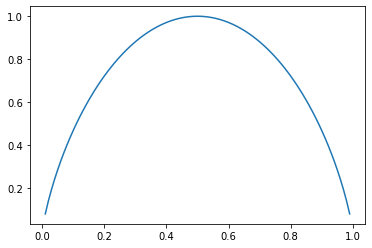

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
y_ent = [entropy(p) if p != 0 else None for p in x]
plt.plot(x, y_ent)

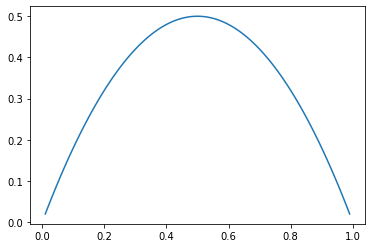

In [3]:
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

x = np.arange(0.0, 1.0, 0.01)
y_gini = [gini(p) if p != 0 else None for p in x]
plt.plot(x, y_gini)

## 常见树模型

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
data = load_iris() 
X, y = data.data[:, :], data.target

clf = DecisionTreeClassifier(criterion='gini')
cross_val_score(clf, X, y, cv=5)

array([0.96666667, 0.96666667, 0.9       , 1.        , 1.        ])

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
data = load_iris() 
X, y = data.data[:, :], data.target

clf = DecisionTreeClassifier(criterion='entropy')
cross_val_score(clf, X, y, cv=5)

array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])

## 随机森林

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
data = load_iris() 
X, y = data.data[:, :], data.target

clf = RandomForestClassifier(n_estimators=100, criterion='gini')
cross_val_score(clf, X, y, cv=5)

array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])

## GBDT

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
data = load_iris() 
X, y = data.data[:, :], data.target

clf = GradientBoostingClassifier()
cross_val_score(clf, X, y, cv=5)

array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])

# XGBoost介绍与使用

- 主页：https://xgboost.readthedocs.io/en/latest/index.html
- 安装：
    - pip安装：https://xgboost.readthedocs.io/en/latest/install.html
    - 源码安装：https://xgboost.readthedocs.io/en/latest/build.html
- GPU使用：https://xgboost.readthedocs.io/en/latest/gpu/index.html
- 模型原理：https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- 支持的树模型：https://xgboost.readthedocs.io/en/latest/treemethod.html
- 自定义评价指标和目标函数：https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
- 类别特征支持：https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html
- 大规模数据训练：
    - 外存数据训练：https://xgboost.readthedocs.io/en/latest/tutorials/external_memory.html
    - 分布式训练：
        - Dask：https://xgboost.readthedocs.io/en/latest/tutorials/dask.html
        - Ray：https://xgboost.readthedocs.io/en/latest/tutorials/ray.html
        - Spark：https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html
- 模型参数：
    - 参数含义：https://xgboost.readthedocs.io/en/latest/parameter.html
    - 参数调优指南：https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- 模型预测：https://xgboost.readthedocs.io/en/latest/prediction.html
- Python API：https://xgboost.readthedocs.io/en/latest/python/python_intro.html
    - API列表：https://xgboost.readthedocs.io/en/latest/python/python_api.html
    - 基础教程：https://xgboost.readthedocs.io/en/latest/python/examples/index.html
    - 回调函数：https://xgboost.readthedocs.io/en/latest/python/callbacks.html

In [34]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("https://cdn.coggle.club/kaggle-flight-delays/flights_10k.csv.zip")

# 提取有用的列
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

# 筛选出部分数据
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

# 进行编码
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)

## 基础使用

### sklearn API
https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [35]:
import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, verbosity=0,
                          use_label_encoder=False,
                          n_estimators=2000, n_jobs=-1, learning_rate=0.1)
model.fit(train,y_train)
print(auc(model, train, test))

(0.9809359358240972, 0.7404874174189319)


### Learning API

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training

In [29]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

param = {'max_depth':10, 'min_child_weight':1, 'learning_rate':0.1}
num_round = 200
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

print(metrics.roc_auc_score(y_train, bst.predict(dtrain)))
print(metrics.roc_auc_score(y_test, bst.predict(dtest)))

1.0
0.7198085295947014


### 模型保存与加载

### GPU速度对比
https://xgboost.readthedocs.io/en/latest/gpu/index.html

> 注意：下面代码需要运行较长时间。

In [39]:
nrows = [100, 1000, 10000, 20000, 50000, 100000]

cpu_time = []
gpu_time = []
for nrow in nrows:
    data = np.random.randint(0, 100, size=(nrow, 10))
    start = time.time()
    model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, 
                          n_estimators=200, n_jobs=-1, learning_rate=0.1)
    model.fit(data[:, :-1], data[:, -1])
    cpu_time.append(time.time() - start)
    
    
    start = time.time()
    model = xgb.XGBClassifier(tree_method='gpu_hist', max_depth=3, min_child_weight=1, 
                          n_estimators=200, n_jobs=-1, learning_rate=0.1)
    model.fit(data[:, :-1], data[:, -1])
    gpu_time.append(time.time() - start)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

Text(0, 0.5, 'Train Seconds')

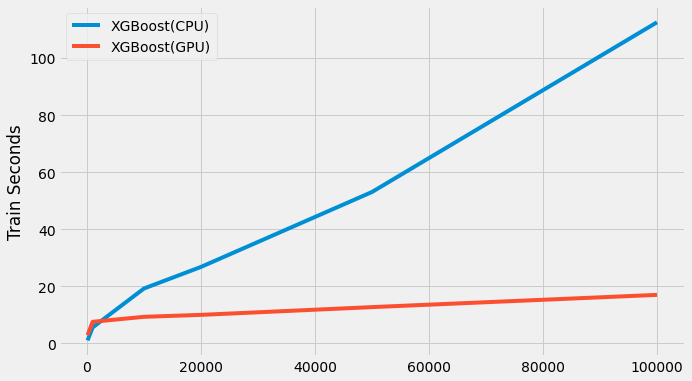

In [40]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, cpu_time)
plt.plot(nrows, gpu_time)
plt.legend(['XGBoost(CPU)', 'XGBoost(GPU)'])
plt.ylabel('Train Seconds')

### 设置类别变量

In [19]:
import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, verbosity=0,
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)
model.fit(train,y_train)
print(auc(model, train, test))

(0.7193900831247766, 0.7172659572679745)


In [20]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = xgb.XGBClassifier(tree_method="gpu_hist",
                          max_depth=3, min_child_weight=1, verbosity=0,
                          n_estimators=20, n_jobs=-1, learning_rate=0.1,
                         enable_categorical=True, use_label_encoder=False)
model.fit(train,y_train)
print(auc(model, train, test))

(0.719947153199857, 0.7220521920755796)


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



### 继续训练

## 回调函数

In [14]:
clf = xgb.XGBClassifier(max_depth=3, min_child_weight=1, verbosity=0,
                          n_estimators=200, n_jobs=-1, learning_rate=0.2)
es = xgboost.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="logloss",
)

clf.fit(train,y_train, eval_set=[(test, y_test)], callbacks=[es], verbose=False)
print(auc(clf, train, test))

(0.7934827493743296, 0.7599417729924185)


In [15]:

clf = xgb.XGBClassifier(max_depth=3, min_child_weight=1,verbosity=0,
                          n_estimators=500, n_jobs=-1)
es = xgboost.callback.LearningRateScheduler(
    lambda epoch: 0.1 * (10 / (epoch+1))
)

clf.fit(train,y_train, eval_set=[(test, y_test)], callbacks=[es], verbose=False)
print(auc(clf, train, test))

(0.7771859358240973, 0.7634393859162507)


## 模型调参

https://xgboost.readthedocs.io/en/latest/parameter.html

### GridSearchCV

In [78]:
%%time

from sklearn.model_selection import GridSearchCV

param_dist = {
    "max_depth": [2,3, 5, 10],
    "min_child_weight" : [1,3,6],
    "n_estimators": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = xgb.XGBClassifier(tree_method="gpu_hist", verbosity=0, silent=True, 
                          enable_categorical=True, use_label_encoder=False)
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, scoring='roc_auc',
                                   verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

CPU times: user 1.48 s, sys: 304 ms, total: 1.78 s
Wall time: 1min 14s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsampl

In [79]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [80]:
grid_search.best_score_

0.7469731536380024

### RandomizedSearch

In [81]:
%%time

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "min_child_weight" : [1,3,6],
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = xgb.XGBClassifier(tree_method="gpu_hist", verbosity=0, silent=True, 
                          enable_categorical=True, use_label_encoder=False)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=3, n_iter=30,
                                   verbose=10, n_jobs=-1, scoring='roc_auc')
random_search.fit(train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-mo

[CV 1/3; 1/108] START learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20
[CV 1/3; 1/108] END learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20;, score=0.625 total time=   1.0s
[CV 3/3; 5/108] START learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=50
[CV 3/3; 5/108] END learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=50;, score=0.676 total time=   0.4s
[CV 3/3; 8/108] START learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=50
[CV 3/3; 8/108] END learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=50;, score=0.677 total time=   0.7s
[CV 1/3; 12/108] START learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200
[CV 1/3; 12/108] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.728 total time=   1.0s
[CV 2/3; 16/108] START learning_rate=0.05, max_depth=3, min_child_weight=6, n_estimators=20
[CV 2/3; 16/108] END learning_rate=0.05, max_depth=3

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

[CV 2/3; 2/108] START learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=50
[CV 2/3; 2/108] END learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=50;, score=0.695 total time=   1.2s
[CV 3/3; 7/108] START learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20
[CV 3/3; 7/108] END learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20;, score=0.638 total time=   0.7s
[CV 1/3; 11/108] START learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50
[CV 1/3; 11/108] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50;, score=0.689 total time=   0.5s
[CV 2/3; 13/108] START learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=20
[CV 2/3; 13/108] END learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=20;, score=0.676 total time=   0.7s
[CV 1/3; 17/108] START learning_rate=0.05, max_depth=3, min_child_weight=6, n_estimators=50
[CV 1/3; 17/108] END learning_rate=0.05, max_depth=3

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

[CV 3/3; 2/108] START learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=50
[CV 3/3; 2/108] END learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=50;, score=0.678 total time=   1.2s
[CV 2/3; 7/108] START learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20
[CV 2/3; 7/108] END learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20;, score=0.659 total time=   0.5s
[CV 1/3; 10/108] START learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=20
[CV 1/3; 10/108] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=20;, score=0.644 total time=   0.5s
[CV 3/3; 12/108] START learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200
[CV 3/3; 12/108] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.746 total time=   1.1s
[CV 3/3; 17/108] START learning_rate=0.05, max_depth=3, min_child_weight=6, n_estimators=50
[CV 3/3; 17/108] END learning_rate=0.05, max_depth

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



CPU times: user 704 ms, sys: 83.6 ms, total: 787 ms
Wall time: 29.5 s


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           tree_method='gpu_hist',
                                           use_label_encoder=False,
                                           val

In [82]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.15000000000000002,
              max_delta_step=0, max_depth=4, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=90, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [83]:
random_search.best_score_

0.7463912072068037

### HalvingGridSearch

In [84]:
%%time

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_dist = {
    "max_depth": [2,3, 5, 10],
    "min_child_weight" : [1,3,6],
    "n_estimators": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = xgb.XGBClassifier(tree_method="gpu_hist", verbosity=0, silent=True, 
                          enable_categorical=True, use_label_encoder=False)
halving_grid_search = HalvingGridSearchCV(model, param_dist, cv=3, scoring='roc_auc',
                                   verbose=1, n_jobs=-1, min_resources=50)
halving_grid_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 50
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/b

----------
iter: 1
n_candidates: 36
n_resources: 150
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/b

----------
iter: 2
n_candidates: 12
n_resources: 450
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-mo

----------
iter: 3
n_candidates: 4
n_resources: 1350
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/b

----------
iter: 4
n_candidates: 2
n_resources: 4050
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

CPU times: user 1.98 s, sys: 256 ms, total: 2.24 s
Wall time: 46.3 s


HalvingGridSearchCV(cv=3,
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraint...
                                            predictor=None, random_state=None,
                                            reg

In [86]:
halving_grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=10, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [87]:
halving_grid_search.best_score_

0.7055844286200884

### HalvingRandomSearchCV

In [89]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "min_child_weight" : [1,3,6],
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = xgb.XGBClassifier(tree_method="gpu_hist", verbosity=0, silent=True, 
                          enable_categorical=True, use_label_encoder=False)
halving_random_search = HalvingRandomSearchCV(model, param_distributions=param_dist, cv=3,
                                   verbose=1, n_jobs=-1, min_resources=50, scoring='roc_auc')
halving_random_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 143
n_resources: 50
Fitting 3 folds for each of 143 candidates, totalling 429 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

----------
iter: 1
n_candidates: 48
n_resources: 150
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/b

----------
iter: 2
n_candidates: 16
n_resources: 450
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR

----------
iter: 3
n_candidates: 6
n_resources: 1350
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

----------
iter: 4
n_candidates: 2
n_resources: 4050
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

HalvingRandomSearchCV(cv=3,
                      estimator=XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              gamma=None, gpu_id=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constrai...
          

In [91]:
halving_random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [92]:
halving_random_search.best_score_

0.7279798755592228

### BayesianOptimization

In [112]:
import warnings
import time
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization

def xgb_eval(max_depth, min_child_weight, n_estimators, learning_rate):    
    params = {
             "eval_metric" : 'auc'
        }
    
    params['max_depth'] = int(max(max_depth, 1))
    params['min_child_weight'] = int(max(min_child_weight, 1))
    params['n_estimators'] = int(max(n_estimators, 1))
    params['learning_rate'] = float(min(learning_rate, 1))
    
    cv_result = xgb.cv(params, xgb.DMatrix(train, y_train), nfold=3, 
                       num_boost_round=500,  early_stopping_rounds=50,
                       seed=0, verbose_eval=None, stratified=True)
    return 1.0 * np.array(cv_result['test-auc-mean']).max()


lgbBO = BayesianOptimization(xgb_eval, {'max_depth': (3, 9),
                                            'min_child_weight': (1,20),
                                            'n_estimators' : (5,200),
                                            'learning_rate': (0.05, 0.5)}, random_state=0)

lgbBO.maximize(init_points=10, n_iter=100, acq='ei', alpha=1e-3)
print(lgbBO.max)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7164   |  0.297    |  7.291    |  12.45    |  111.3    |
|  2        |  0.7266   |  0.2406   |  6.875    |  9.314    |  178.9    |
|  3        |  0.7224   |  0.4836   |  5.301    |  16.04    |  108.1    |
|  4        |  0.7067   |  0.3056   |  8.554    |  2.35     |  21.99    |
|  5        |  0.7296   |  0.0591   |  7.996    |  15.78    |  174.7    |
|  6        |  0.7072   |  0.4904   |  7.795    |  9.768    |  157.2    |
|  7        |  0.7288   |  0.1032   |  6.84     |  3.724    |  189.2    |
|  8        |  0.7237   |  0.2848   |  5.488    |  6.027    |  156.0    |
|  9        |  0.727    |  0.2553   |  6.411    |  1.357    |  125.4    |
|  10       |  0.719    |  0.3254   |  6.702    |  18.93    |  138.0    |
|  11       |  0.7156   |  0.3183   |  7.821    |  13.68    |  104.9    |
|  12       |  0.7328   |  0.2511   | 

## 模型可视化

https://lightgbm.readthedocs.io/en/latest/Python-API.html#plotting

In [113]:
import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, verbosity=0,
                          n_estimators=2000, n_jobs=-1, learning_rate=0.1)
model.fit(train,y_train)
print(auc(model, train, test))

(0.9809359358240972, 0.7404874174189319)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

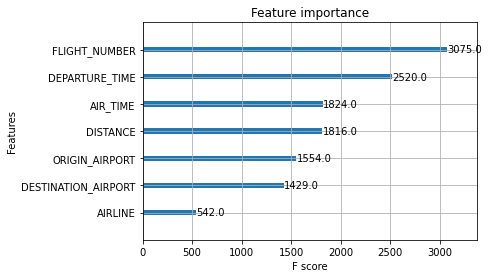

In [114]:
xgb.plot_importance(model)

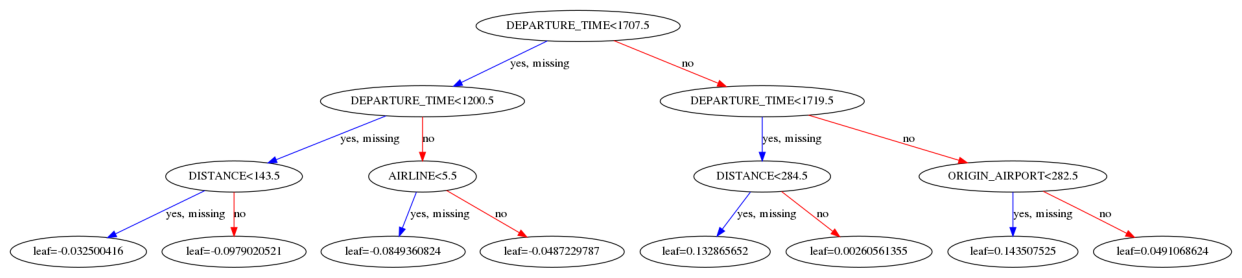

In [124]:
fig, ax = plt.subplots(figsize=(22, 10))
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()

# LightGBM介绍与使用

- 官网：https://lightgbm.readthedocs.io/en/latest/
- 安装教程：https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html
- 模型参数：
    - 参数解释：https://lightgbm.readthedocs.io/en/latest/Parameters.html
    - 参数调优：https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
- Python API：https://lightgbm.readthedocs.io/en/latest/Python-API.html

In [1]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("https://cdn.coggle.club/kaggle-flight-delays/flights_10k.csv.zip")

# 提取有用的列
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

# 筛选出部分数据
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

# 进行编码
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)

## 基础使用

### sklearn API

https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import lightgbm as lgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                           verbose=-1, verbosity=-1,
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)
model.fit(train,y_train)
print(auc(model, train, test))

[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
(0.7250291048444761, 0.718952775396305)


### Learning API

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train

In [6]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))


d_train = lgb.Dataset(train, label=y_train, free_raw_data=False)
params = {"max_depth": 3, "learning_rate" : 0.1, 
          "num_leaves": 900,  "n_estimators": 20, 'verbose': -1}

model = lgb.train(params, d_train)
print(auc2(model, train, test))

(0.7223327449052556, 0.7163025114730949)


### 模型保存与加载

### GPU速度对比

In [7]:
nrows = [100, 1000, 10000, 20000, 50000, 100000]

cpu_time = []
gpu_time = []
for nrow in nrows:
    data = np.random.randint(0, 100, size=(nrow, 10))
    start = time.time()
    model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                               verbose=-1, verbosity=-1,
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)
    model.fit(data[:, :-1], data[:, -1])
    cpu_time.append(time.time() - start)
    
    start = time.time()
    model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                               device="gpu",
                               verbose=-1, verbosity=-1,
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)
    model.fit(data[:, :-1], data[:, -1])
    gpu_time.append(time.time() - start)

[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1


Text(0, 0.5, 'Train Seconds')

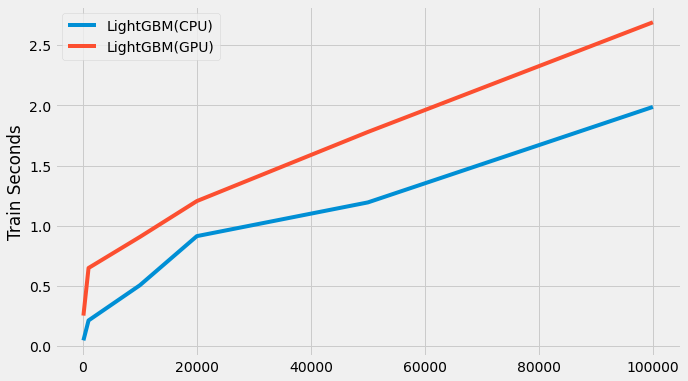

In [8]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, cpu_time)
plt.plot(nrows, gpu_time)
plt.legend(['LightGBM(CPU)', 'LightGBM(GPU)'])
plt.ylabel('Train Seconds')

### 设置类别变量

In [134]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))


model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)

#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model.fit(train,y_train, categorical_feature = cate_features_name)
print(auc(model, train, test))

(0.7954076354129425, 0.7572494830803369)


In [135]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))

d_train = lgb.Dataset(train, label=y_train, free_raw_data=False)
params = {"max_depth": 3, "learning_rate" : 0.1, 
          "num_leaves": 900,  "n_estimators": 20, 'verbose': -1}

#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
print(auc2(model2, train, test))

(0.7973879379692528, 0.7585995679728343)


### 继续训练

## 回调函数

In [11]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))


model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                           verbose=-1, verbosity=-1,
                          n_estimators=200, n_jobs=-1, learning_rate=0.1)

call_back = [
    lgb.early_stopping(10),
    lgb.log_evaluation(10),
]

#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model.fit(train,y_train, categorical_feature = cate_features_name,
          eval_set=(test, y_test),
          callbacks=call_back)
print(auc(model, train, test))

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.454198
[20]	valid_0's binary_logloss: 0.438246
[30]	valid_0's binary_logloss: 0.431437
[40]	valid_0's binary_logloss: 0.428976
[50]	valid_0's binary_logloss: 0.427535
[60]	valid_0's binary_logloss: 0.426829
[70]	valid_0's binary_logloss: 0.426902
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.426368
(0.837816969074008, 0.7667284448703078)


## 模型调参

### GridSearch

In [19]:
%%time

from sklearn.model_selection import GridSearchCV

param_dist = {
    "max_depth": [2,3, 5, 10],
    "min_child_weight" : [1,3,6],
    "n_estimators": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = lgb.LGBMClassifier(verbose=-1, verbosity=-1)
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, scoring='roc_auc',
                                   verbose=1, n_jobs=-1)
grid_search.fit(train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 36/108] END learning_rate=0.05, max_depth=10, min_child_weight=6, n_estimators=200;, score=0.734 total time=   0.3s
[CV 2/3; 36/108] START learning_rate=0.05, max_depth=10, min_child_weight=6, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 2/3; 36/108] END learning_rate=0.05, max_depth=10, min_child_weight=6, n_estimators=200;, score=0.743 total time=   0.3s
[CV 3/3; 36/108] START learning_rate=0.05, max_depth=10, min_child_weight=6, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 3/3; 36/108] END learning_rate=0.05, max_depth=10, min_child_weight=6, n_estimators=200;, score=0.752 total time=   0.3s
[CV 3/3; 75/108] START learning_rate=0.15, max_depth=2, min_child_weight=1, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: 

GridSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1, verbosity=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 5, 10],
                         'min_child_weight': [1, 3, 6],
                         'n_estimators': [20, 50, 200]},
             scoring='roc_auc', verbose=1)

In [20]:
grid_search.best_estimator_

LGBMClassifier(max_depth=5, min_child_weight=6, n_estimators=200, verbose=-1,
               verbosity=-1)

In [21]:
grid_search.best_score_

0.7454218719321384

### RandomizedSearch

In [22]:
%%time

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "min_child_weight" : [1,3,6],
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = lgb.LGBMClassifier(verbose=-1, verbosity=-1)
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   cv=3, n_iter=30,
                                   verbose=10, n_jobs=-1, scoring='roc_auc')
random_search.fit(train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 2/3; 57/108] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200;, score=0.737 total time=   0.2s
[CV 3/3; 57/108] START learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 3/3; 57/108] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200;, score=0.756 total time=   0.2s
[CV 1/3; 58/108] START learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=20
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 1/3; 58/108] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=20;, score=0.706 total time=   0.0s
[CV 1/3; 81/108] START learning_rate=0.15, max_depth=2, min_child_weight=6, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1, verbosity=-1),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 3, 6],
                                        'n_estimators': [20, 30, 40, 50, 60, 70,
                                                         80, 90, 100, 110, 120,
                                                         130, 140, 150, 160,
                                                         170, 180, 190]},
                   scoring='roc_auc', verbose=10)

In [23]:
random_search.best_estimator_

LGBMClassifier(learning_rate=0.2, max_depth=3, min_child_weight=3,
               n_estimators=180, verbose=-1, verbosity=-1)

In [24]:
random_search.best_score_

0.7432480891387426

### HalvingGridSearch

In [25]:
%%time

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_dist = {
    "max_depth": [2,3, 5, 10],
    "min_child_weight" : [1,3,6],
    "n_estimators": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = lgb.LGBMClassifier(verbose=-1, verbosity=-1)
halving_grid_search = HalvingGridSearchCV(model, param_dist, cv=3, scoring='roc_auc',
                                   verbose=1, n_jobs=-1, min_resources=50)
halving_grid_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 50
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 2/3; 104/108] END learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=50;, score=0.744 total time=   0.1s
[CV 3/3; 104/108] START learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=50
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 3/3; 104/108] END learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=50;, score=0.745 total time=   0.1s
[CV 2/3; 108/108] START learning_rate=0.15, max_depth=10, min_child_weight=6, n_estimators=200
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[CV 2/3; 108/108] END learning_rate=0.15, max_depth=10, min_child_weight=6, n_estimators=200;, score=0.

HalvingGridSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1, verbosity=-1),
                    min_resources=50, n_jobs=-1,
                    param_grid={'learning_rate': [0.05, 0.1, 0.15],
                                'max_depth': [2, 3, 5, 10],
                                'min_child_weight': [1, 3, 6],
                                'n_estimators': [20, 50, 200]},
                    scoring='roc_auc', verbose=1)

In [26]:
halving_grid_search.best_estimator_

LGBMClassifier(learning_rate=0.05, max_depth=5, min_child_weight=6,
               n_estimators=50, verbose=-1, verbosity=-1)

In [27]:
halving_grid_search.best_score_

0.7062200337419636

### HalvingRandomSearch

In [28]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "min_child_weight" : [1,3,6],
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = lgb.LGBMClassifier(verbose=-1, verbosity=-1)
halving_random_search = HalvingRandomSearchCV(model, param_distributions=param_dist, cv=3,
                                   verbose=1, n_jobs=-1, min_resources=50, scoring='roc_auc')
halving_random_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 143
n_resources: 50
Fitting 3 folds for each of 143 candidates, totalling 429 fits
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=-1

HalvingRandomSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1, verbosity=-1),
                      min_resources=50, n_jobs=-1,
                      param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
                                           'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                           'min_child_weight': [1, 3, 6],
                                           'n_estimators': [20, 30, 40, 50, 60,
                                                            70, 80, 90, 100,
                                                            110, 120, 130, 140,
                                                            150, 160, 170, 180,
                                                            190]},
                      scoring='roc_auc', verbose=1)

In [29]:
halving_random_search.best_estimator_

LGBMClassifier(max_depth=5, min_child_weight=3, n_estimators=30, verbose=-1,
               verbosity=-1)

In [30]:
halving_random_search.best_score_

0.7156815821537957

### BayesianOptimization

In [6]:
import warnings
import time
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization

def lgb_eval(max_depth, min_child_weight, n_estimators, learning_rate):    
    params = {
        "metric" : 'auc',
        'verbose':-1
    }
    
    params['max_depth'] = int(max(max_depth, 1))
    params['min_child_weight'] = int(max(min_child_weight, 1))
    params['n_estimators'] = int(max(n_estimators, 1))
    params['learning_rate'] = float(min(learning_rate, 1))
    
    cv_result = lgb.cv(params, lgb.Dataset(train, label=y_train), nfold=3, 
                       num_boost_round=500, 
                       seed=0,stratified=True)
    return 1.0 * np.array(cv_result['auc-mean']).max()

lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (3, 9),
                                            'min_child_weight': (1,20),
                                            'n_estimators' : (5,200),
                                            'learning_rate': (0.05, 0.5)}, random_state=0)

lgbBO.maximize(init_points=10, n_iter=100, acq='ei', alpha=1e-3)
print(lgbBO.max)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.728    |  0.297    |  7.291    |  12.45    |  111.3    |
|  2        |  0.7255   |  0.2406   |  6.875    |  9.314    |  178.9    |
|  3        |  0.7195   |  0.4836   |  5.301    |  16.04    |  108.1    |
|  4        |  0.7192   |  0.3056   |  8.554    |  2.35     |  21.99    |
|  5        |  0.7338   |  0.0591   |  7.996    |  15.78    |  174.7    |
|  6        |  0.7143   |  0.4904   |  7.795    |  9.768    |  157.2    |
|  7        |  0.7336   |  0.1032   |  6.84     |  3.724    |  189.2    |
|  8        |  0.7281   |  0.2848   |  5.488    |  6.027    |  156.0    |
|  9        |  0.7269   |  0.2553   |  6.411    |  1.357    |  125.4    |
|  10       |  0.7278   |  0.3254   |  6.702    |  18.93    |  138.0    |
|  11       |  0.725    |  0.3183   |  7.821    |  13.68    |  104.9    |
|  12       |  0.7305   |  0.2511   | 

## 模型可视化

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import lightgbm as lgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = lgb.LGBMClassifier(max_depth=3, min_child_weight=1, 
                          n_estimators=20, n_jobs=-1, learning_rate=0.1)
model.fit(train,y_train)
print(auc(model, train, test))

(0.7250291048444761, 0.718952775396305)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

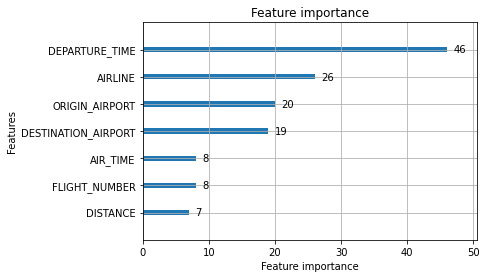

In [6]:
lgb.plot_importance(model)

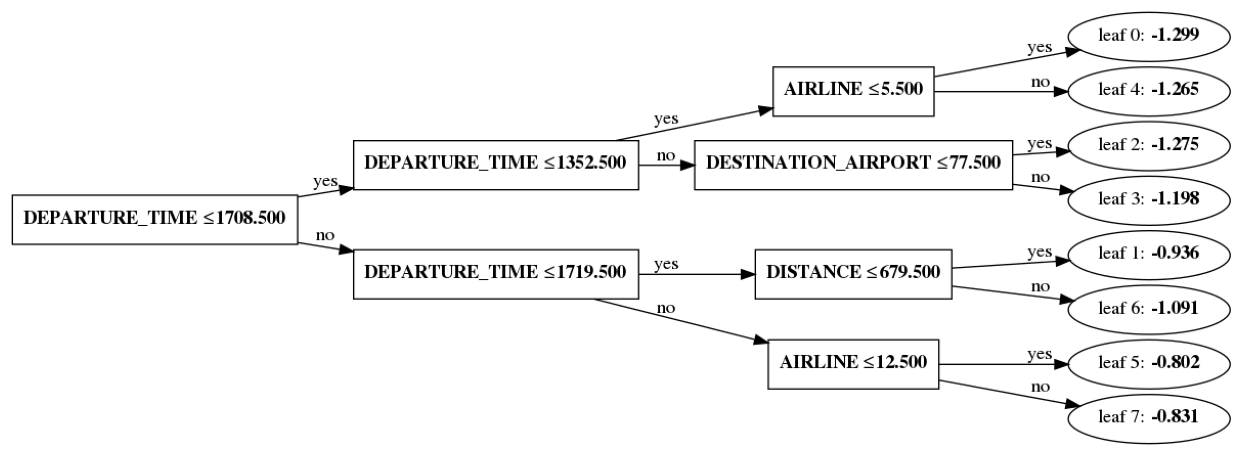

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(22, 10))
lgb.plot_tree(model, ax=ax, tree_index=0)
plt.show()

# CatBoost介绍与使用

https://catboost.ai/en/docs/

In [23]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("https://cdn.coggle.club/kaggle-flight-delays/flights_10k.csv.zip")

# 提取有用的列
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

# 筛选出部分数据
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

# 进行编码
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)

## 基础使用

In [25]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = CatBoostClassifier(iterations=20,
                           depth=3,
                           learning_rate=0.3,
                           loss_function='Logloss',
                           verbose=False)
# train the model
model.fit(train, y_train, verbose=0)
print(auc(model, train, test))

(0.7248280523775474, 0.733506375342512)


### 模型保存与加载

### GPU速度对比

In [28]:
nrows = [100, 1000, 10000, 20000, 50000, 100000]

cpu_time = []
gpu_time = []
for nrow in nrows:
    data = np.random.randint(0, 100, size=(nrow, 10))
    start = time.time()
    model = CatBoostClassifier(iterations=200,
                               depth=3,
                               learning_rate=0.3,
                               loss_function='MultiClass',
                               verbose=True)
    model.fit(data[:, :-1], data[:, -1], verbose=0)
    cpu_time.append(time.time() - start)
    
    
    start = time.time()
    model = CatBoostClassifier(iterations=200,
                               depth=3,
                               learning_rate=0.3,
                               loss_function='MultiClass',
                               task_type="GPU",
                               verbose=True)
    model.fit(data[:, :-1], data[:, -1], verbose=0)
    gpu_time.append(time.time() - start)

Text(0, 0.5, 'Train Seconds')

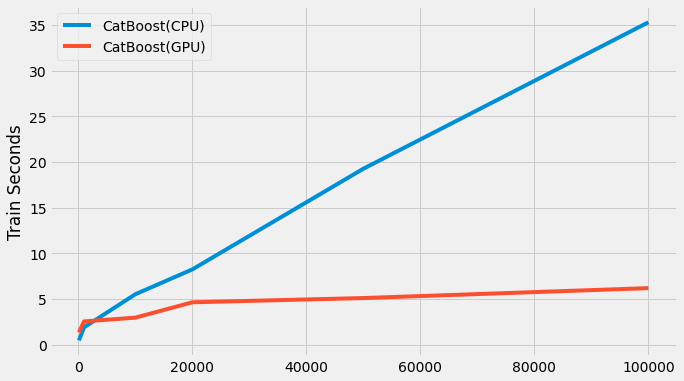

In [29]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, cpu_time)
plt.plot(nrows, gpu_time)
plt.legend(['CatBoost(CPU)', 'CatBoost(GPU)'])
plt.ylabel('Train Seconds')

### 设置类别变量

In [30]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = CatBoostClassifier(iterations=20,
                           depth=3,
                           learning_rate=0.3,
                           loss_function='Logloss',
                           verbose=False)
# train the model
cat_features_index = [0,1,2,3,4,5,6]
model.fit(train, y_train, verbose=0, cat_features= cat_features_index)
print(auc(model, train, test))

(0.7818634362710046, 0.7751268134214198)


### 继续训练

## 回调函数

## 模型调参

- https://catboost.ai/en/docs/references/training-parameters/
- https://catboost.ai/en/docs/concepts/loss-functions
- https://catboost.ai/en/docs/concepts/parameter-tuning

### GridSearchCV

In [35]:
%%time

from sklearn.model_selection import GridSearchCV

param_dist = {
    "depth": [2,3, 5, 10],
    "iterations": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = CatBoostClassifier(loss_function='Logloss', task_type="GPU",
                           verbose=False)
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, scoring='roc_auc',
                                   verbose=1, n_jobs=1)
grid_search.fit(train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CPU times: user 3min 34s, sys: 34.4 s, total: 4min 9s
Wall time: 1min 50s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f72cdf11990>,
             n_jobs=1,
             param_grid={'depth': [2, 3, 5, 10], 'iterations': [20, 50, 200],
                         'learning_rate': [0.05, 0.1, 0.15]},
             scoring='roc_auc', verbose=1)

In [38]:
grid_search.best_estimator_.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'iterations': 200,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '-1',
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 3,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'min_data_in_leaf': 

In [37]:
grid_search.best_score_

0.7378616029303307

### RandomizedSearch

In [41]:
%%time

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = CatBoostClassifier(loss_function='Logloss', task_type="GPU",
                           verbose=False)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=3, n_iter=30,
                                   verbose=1, n_jobs=1, scoring='roc_auc')
random_search.fit(train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CPU times: user 2min 24s, sys: 24 s, total: 2min 48s
Wall time: 1min 16s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f72c607b160>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [20, 30, 40, 50, 60, 70,
                                                         80, 90, 100, 110, 120,
                                                         130, 140, 150, 160,
                                                         170, 180, 190]},
                   scoring='roc_auc', verbose=1)

In [ ]:
random_search.best_estimator_.get_all_params()

In [43]:
random_search.best_score_

0.7408738417080946

### HalvingGridSearch

In [84]:
%%time

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_dist = {
    "max_depth": [2,3, 5, 10],
    "n_estimators": [20, 50, 200],
    "learning_rate": [0.05, 0.1,0.15]
}

model = CatBoostClassifier(loss_function='Logloss', task_type="GPU",
                           verbose=False)
halving_grid_search = HalvingGridSearchCV(model, param_dist, cv=3, scoring='roc_auc',
                                   verbose=1, n_jobs=-1, min_resources=50)
halving_grid_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 50
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/b

----------
iter: 1
n_candidates: 36
n_resources: 150
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/b

----------
iter: 2
n_candidates: 12
n_resources: 450
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-mo

----------
iter: 3
n_candidates: 4
n_resources: 1350
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.


ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/b

----------
iter: 4
n_candidates: 2
n_resources: 4050
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR

CPU times: user 1.98 s, sys: 256 ms, total: 2.24 s
Wall time: 46.3 s


HalvingGridSearchCV(cv=3,
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraint...
                                            predictor=None, random_state=None,
                                            reg

In [86]:
halving_grid_search.best_estimator_.get_all_params()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=10, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [87]:
halving_grid_search.best_score_

0.7055844286200884

### HalvingRandomSearchCV

In [45]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

param_dist = {
    "max_depth": list(range(3, 10)),
    "n_estimators": list(range(20, 200, 10)),
    "learning_rate": np.linspace(0.05, 0.5, 10)
}

model = CatBoostClassifier(loss_function='Logloss', task_type="GPU",
                           verbose=False)
halving_random_search = HalvingRandomSearchCV(model, param_distributions=param_dist, cv=3,
                                   verbose=1, n_jobs=1, min_resources=50, scoring='roc_auc')
halving_random_search.fit(train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 50
max_resources_: 7194
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 143
n_resources: 50
Fitting 3 folds for each of 143 candidates, totalling 429 fits
----------
iter: 1
n_candidates: 48
n_resources: 150
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 2
n_candidates: 16
n_resources: 450
Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

In [ ]:
halving_random_search.best_estimator_.get_all_params()

In [92]:
halving_random_search.best_score_

0.7279798755592228

### BayesianOptimization

In [56]:
import warnings
import time
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
from catboost import Pool, cv

def cat_eval(depth, iterations, learning_rate):    
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "GPU",
    }
    
    params['depth'] = int(max(4, 1))
    params['iterations'] = int(max(200, 1))
    params['learning_rate'] = float(min(0.1, 1))
    
    cat_features_index = [0,1,2,3,4,5,6]
    cv_dataset = Pool(data=train, label=y_train, cat_features=cat_features_index)
    cv_result = cv(cv_dataset, params, fold_count=3, verbose=False)
    return 1.0 * np.array(cv_result['test-AUC-mean']).max()


lgbBO = BayesianOptimization(cat_eval, {'depth': (3, 9),
                                            'iterations' : (5,200),
                                            'learning_rate': (0.05, 0.5)}, random_state=0)

lgbBO.maximize(init_points=10, n_iter=20, acq='ei', alpha=1e-3)
print(lgbBO.max)

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
Training on fold [0/3]


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

bestTest = 0.7633240223
bestIteration = 198
Training on fold [1/3]
bestTest = 0.7559335828
bestIteration = 192
Training on fold [2/3]
bestTest = 0.782453537
bestIteration = 197
|  1        |  0.7672   |  6.293    |  144.5    |  0.3212   |
Training on fold [0/3]
bestTest = 0.7633240223
bestIteration = 198
Training on fold [1/3]
bestTest = 0.7559335828
bestIteration = 192
Training on fold [2/3]
bestTest = 0.782453537
bestIteration = 197
|  2        |  0.7672   |  6.269    |  87.61    |  0.3407   |
Training on fold [0/3]
bestTest = 0.7633240223
bestIteration = 198
Training on fold [1/3]
bestTest = 0.7559335828
bestIteration = 192
Training on fold [2/3]
bestTest = 0.782453537
bestIteration = 197
|  3        |  0.7672   |  5.626    |  178.9    |  0.4836   |
Training on fold [0/3]
bestTest = 0.7633240223
bestIteration = 198
Training on fold [1/3]
bestTest = 0.7559335828
bestIteration = 192
Training on fold [2/3]
bestTest = 0.782453537
bestIteration = 197
|  4        |  0.7672   |  5.301    |

## 模型可视化

https://catboost.ai/en/docs/concepts/model-analysis

(0.7818634362710046, 0.7751268134214198)


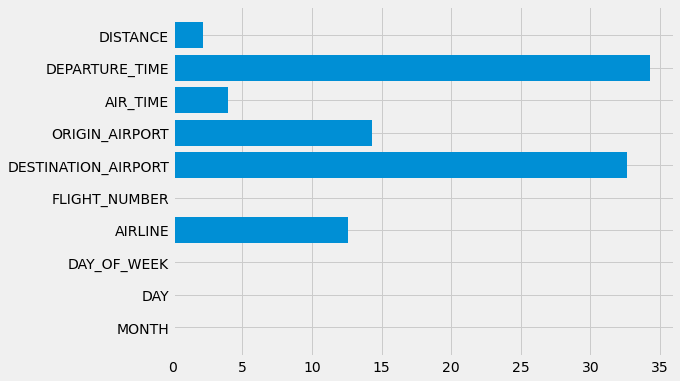

In [69]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

model = CatBoostClassifier(iterations=20,
                           depth=3,
                           learning_rate=0.3,
                           loss_function='Logloss',
                           verbose=False)
# train the model
cat_features_index = [0,1,2,3,4,5,6]
model.fit(train, y_train, verbose=0, cat_features= cat_features_index)
print(auc(model, train, test))

_, ax = plt.subplots(1, 1, figsize=(8, 6))

ylocs = np.arange(train.shape[1])
ax.barh(ylocs, model.get_feature_importance(), align='center')
_ = ax.set_yticks(ylocs)
_ = ax.set_yticklabels(train.columns)

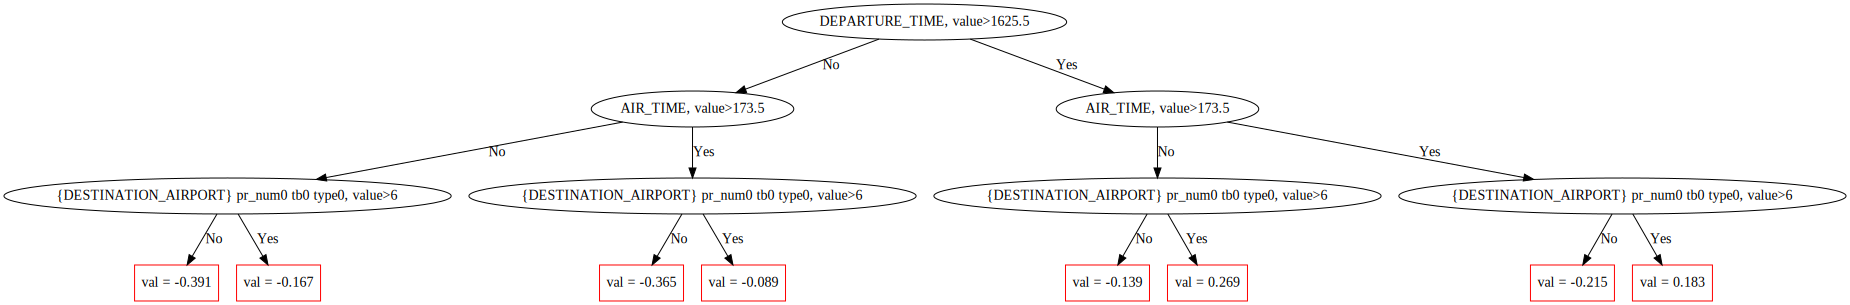

In [80]:
pool = Pool(train, y_train, cat_features=cat_features_index, 
            feature_names=list(train.columns))

model.plot_tree(
    tree_idx=0,
    pool=pool
)

# 树模型部署&加速

## TreeLite

- https://treelite.readthedocs.io/en/latest/index.html
- https://mlsys.org/Conferences/doc/2018/196.pdf

In [10]:
import treelite
import numpy as np
import time

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=1000)

### XGBoost

In [22]:
import xgboost
dtrain = xgboost.DMatrix(X, label=y)
params = {'max_depth':3, 'eta':1, 'eval_metric':'rmse'}
bst = xgboost.train(params, dtrain, 20, [(dtrain, 'train')])

[0]	train-rmse:0.13043
[1]	train-rmse:0.10912
[2]	train-rmse:0.09860
[3]	train-rmse:0.08706
[4]	train-rmse:0.07476
[5]	train-rmse:0.06609
[6]	train-rmse:0.06124
[7]	train-rmse:0.05663
[8]	train-rmse:0.05056
[9]	train-rmse:0.04522
[10]	train-rmse:0.03706
[11]	train-rmse:0.03491
[12]	train-rmse:0.03274
[13]	train-rmse:0.03042
[14]	train-rmse:0.02808
[15]	train-rmse:0.02518
[16]	train-rmse:0.02381
[17]	train-rmse:0.02223
[18]	train-rmse:0.02082
[19]	train-rmse:0.01981


In [23]:
model = treelite.Model.from_xgboost(bst)

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', 
                 verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[11:51:06] ../src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[11:51:06] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./tmpav9d2gp0 into object files (*.o)...
[11:51:07] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:135: Generating dynamic shared library ./tmpav9d2gp0/predictor.so...
[11:51:07] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/__init__.py:282: Generated shared library in 0.59 seconds
[11:51:07] /home/lyz/.local/lib/python3.9/site-packages/treelite_runtime/predictor.py:159: Dynamic shared library /home/lyz/work/notebooks/kaggle书/ch05-树模型/mymodel.so has been successfully loaded into memory


In [24]:
nrows = [1000, 10000, 100000, 200000]
xgb_time = []
xgb_tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    dtrain = xgboost.DMatrix(data)
    
    start = time.time()
    _ = bst.predict(dtrain)
    xgb_time.append(time.time() - start)
    
    batch = treelite_runtime.DMatrix(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    xgb_tree_lite.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


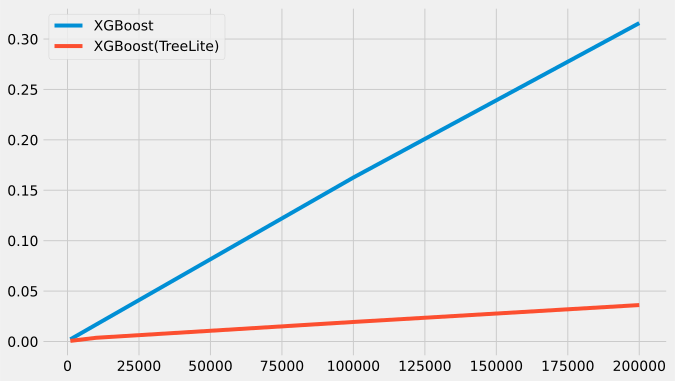

In [26]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, xgb_tree_lite)
plt.legend(['XGBoost', 'XGBoost(TreeLite)'])

### LigthGBM

In [27]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'max_depth':3,
    'metric': 'binary_logloss',
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10)

gbm.save_model('model.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [28]:
# model = treelite.Model.from_xgboost(bst)
model = treelite.Model.load('model.txt', model_format='lightgbm')

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

[11:52:14] ../src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[11:52:14] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./tmp3fi0qhav into object files (*.o)...
[11:52:14] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:135: Generating dynamic shared library ./tmp3fi0qhav/predictor.so...
[11:52:14] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/__init__.py:282: Generated shared library in 0.82 seconds
[11:52:14] /home/lyz/.local/lib/python3.9/site-packages/treelite_runtime/predictor.py:159: Dynamic shared library /home/lyz/work/notebooks/kaggle书/ch05-树模型/mymodel.so has been successfully loaded into memory


In [29]:
nrows = [1000, 10000, 100000, 200000]

lgb_time = []
lgb_tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = gbm.predict(data)
    lgb_time.append(time.time() - start)
    
    batch = treelite_runtime.DMatrix(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    lgb_tree_lite.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


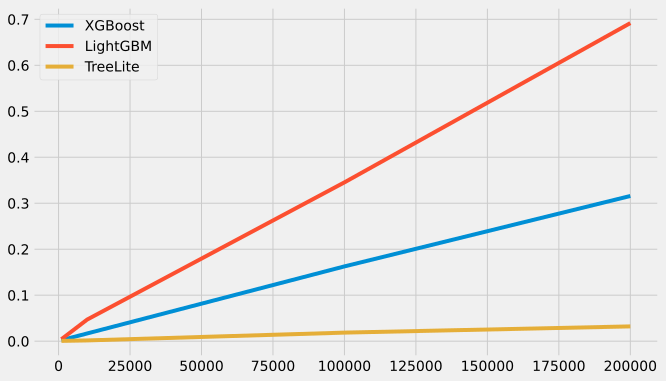

In [32]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, lgb_time)
plt.plot(nrows, lgb_tree_lite)
plt.legend(['XGBoost','LightGBM', 'TreeLite'])

### sklean/RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1).fit(X, y)

In [34]:
# model = treelite.Model.from_xgboost(bst)
model = treelite.sklearn.import_model(rf)

toolchain = 'gcc'   # change this value as necessary
model.export_lib(toolchain=toolchain, libpath='./mymodel.so', verbose=True)

import treelite_runtime     # runtime module
predictor = treelite_runtime.Predictor('./mymodel.so', verbose=True)

/home/lyz/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


[11:53:27] ../src/compiler/ast/split.cc:24: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[11:53:27] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:105: Compiling sources files in directory ./tmpr03egw0y into object files (*.o)...
[11:53:28] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/util.py:135: Generating dynamic shared library ./tmpr03egw0y/predictor.so...
[11:53:28] /home/lyz/.local/lib/python3.9/site-packages/treelite/contrib/__init__.py:282: Generated shared library in 0.84 seconds
[11:53:28] /home/lyz/.local/lib/python3.9/site-packages/treelite_runtime/predictor.py:159: Dynamic shared library /home/lyz/work/notebooks/kaggle书/ch05-树模型/mymodel.so has been successfully loaded into memory


In [35]:
nrows = [1000, 10000, 100000, 200000]
rf_time = []
rf_tree_lite = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = rf.predict(data)
    rf_time.append(time.time() - start)
    
    batch = treelite_runtime.DMatrix(data)
    
    start = time.time()
    _ = predictor.predict(batch)
    rf_tree_lite.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


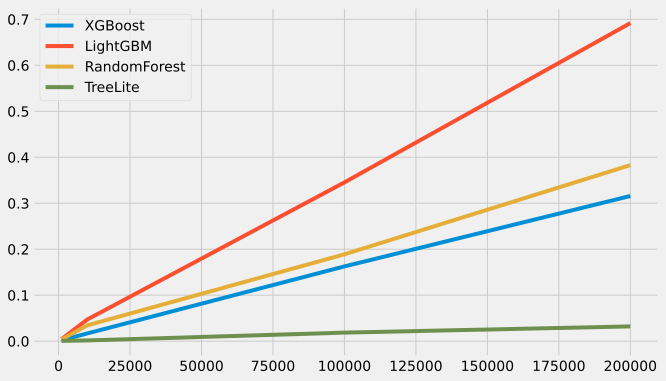

In [40]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, lgb_time)
plt.plot(nrows, rf_time)
plt.plot(nrows, lgb_tree_lite)
plt.legend(['XGBoost','LightGBM', 'RandomForest','TreeLite'])
plt.savefig('tmp.png', dpi=200, bbox_inches='tight')

## hummingbird

https://github.com/microsoft/hummingbird

In [1]:
import treelite
import numpy as np
import time

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=1000)

### XGBoost

In [2]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=20, max_depth=3)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', ...)

In [3]:
from hummingbird.ml import convert

hb_model = convert(model, 'torch', X[0:1])

/home/lyz/.local/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [12]:
nrows = [1000, 10000, 100000, 200000]

xgb_time = []
hb_time = []
hb_gpu_time = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = model.predict(data)
    xgb_time.append(time.time() - start)
    
    hb_model = convert(model, 'torch', X[0:1])
    start = time.time()
    _ = hb_model.predict(data)
    hb_time.append(time.time() - start)
    
    hb_model.to('cuda')
    start = time.time()
    _ = hb_model.predict(data)
    hb_gpu_time.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


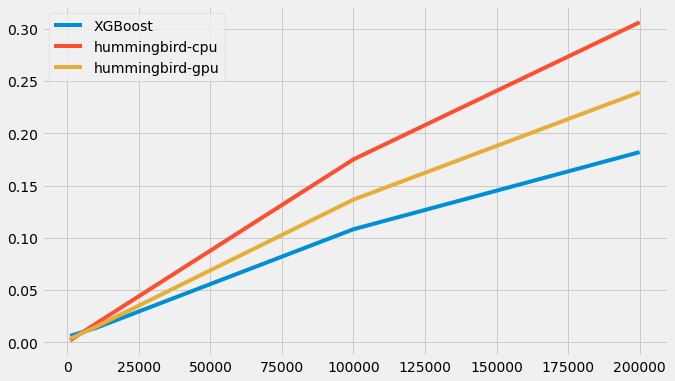

In [13]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, xgb_time)
plt.plot(nrows, hb_time)
plt.plot(nrows, hb_gpu_time)
plt.legend(['XGBoost', 'hummingbird-cpu', 'hummingbird-gpu'])

### LightGBM

In [16]:
import lightgbm as lgb

model = lgb.LGBMClassifier(n_estimators=20, max_depth=3, verbose=-1)
model.fit(X, y)

LGBMClassifier(max_depth=3, n_estimators=20, verbose=-1)

In [17]:
nrows = [1000, 10000, 100000, 200000]

lgb_time = []
hb_time = []
hb_gpu_time = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = model.predict(data)
    lgb_time.append(time.time() - start)
    
    hb_model = convert(model, 'torch', X[0:1])
    start = time.time()
    _ = hb_model.predict(data)
    hb_time.append(time.time() - start)
    
    hb_model.to('cuda')
    start = time.time()
    _ = hb_model.predict(data)
    hb_gpu_time.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


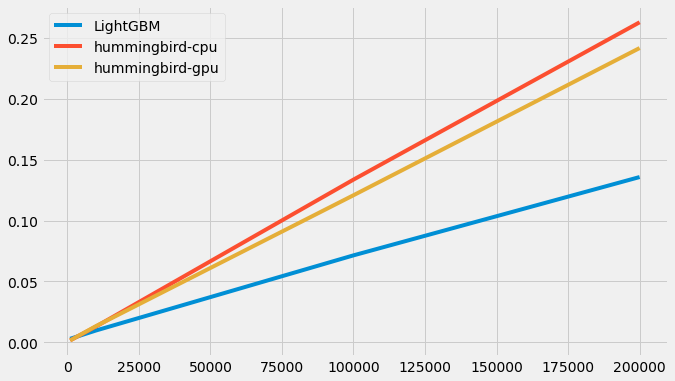

In [19]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, lgb_time)
plt.plot(nrows, hb_time)
plt.plot(nrows, hb_gpu_time)
plt.legend(['LightGBM', 'hummingbird-cpu', 'hummingbird-gpu'])

### sklean/RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1).fit(X, y)

In [21]:
nrows = [1000, 10000, 100000, 200000]

rf_time = []
hb_time = []
hb_gpu_time = []
for nrow in nrows:
    data = np.random.random((nrow, 1000))
    start = time.time()
    _ = model.predict(data)
    rf_time.append(time.time() - start)
    
    hb_model = convert(model, 'torch', X[0:1])
    start = time.time()
    _ = hb_model.predict(data)
    hb_time.append(time.time() - start)
    
    hb_model.to('cuda')
    start = time.time()
    _ = hb_model.predict(data)
    hb_gpu_time.append(time.time() - start)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


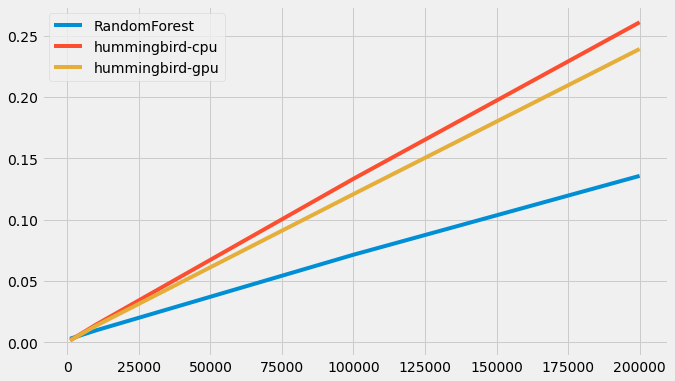

In [22]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))
plt.plot(nrows, lgb_time)
plt.plot(nrows, hb_time)
plt.plot(nrows, hb_gpu_time)
plt.legend(['RandomForest', 'hummingbird-cpu', 'hummingbird-gpu'])